# Crime Patterns and Arrest Trends Due to SocioEconomic Disparity: A Data Science Analysis

## Project Introduction
Our project investigates disparities in crime and arrest trends across neighborhoods in NYC, with a focus on how these trends correlate with income levels, race demographics, and geographic location.

### Research Questions
- Do crime and arrest rates vary by location?
- Do areas with lower income experience higher police activity and crime rates?
- Do we see similar trends of systematic discrimination in areas with higher population of people of color?

### Data Sources
We are using multiple public datasets from data.gov including:
- **NYPD Shooting Incident Data**
- **NYC Crimes 2001–Present**
- **NYC Arrests Data**

## Project Status
Since our check-in proposal slides, there has been a significant change to the project scope. Initially, we planned to analyze crime and arrest trends using datasets from Chicago. However, due to data limitations, we decided to switch our focus to datasets from the NYPD. This change aligns with our original objective of analyzing crime and arrest trends by location, income, and racial demographics, but with a different geographic focus. Aside from this switch, we have not removed or added any major components to the project thus far.


In [150]:
import pandas as pd
import numpy as np
import re                        
from datetime import datetime
import zipfile

import matplotlib.pyplot as plt   
import seaborn as sns
import plotly.express as px 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer          

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score


In [152]:
with zipfile.ZipFile("NYPD_Hate_Crimes.zip", "r") as z:
    with z.open("NYPD_Hate_Crimes.csv") as f:
        df_hate_crimes = pd.read_csv(f)
columns_to_drop = ['Complaint Precinct Code', 'Law Code Category Description',  'PD Code Description','Bias Motive Description','Month Number','Patrol Borough Name','Full Complaint ID'
]
df_hate_crimes = df_hate_crimes.drop(columns=[col for col in columns_to_drop if col in  df_hate_crimes.columns])
df_hate_crimes = df_hate_crimes.drop_duplicates()
df_hate_crimes = df_hate_crimes.dropna()
#print(df_hate_crimes.head())


In [154]:
with zipfile.ZipFile("NYPD_Arrest_Data__Year_to_Date_.zip", "r") as z:
    with z.open("NYPD_Arrest_Data__Year_to_Date_.csv") as f:
        df_arrest = pd.read_csv(f)
df_shooting.replace("(null)", np.nan, inplace=True)
#print("Columns in the Arrest DataFrame:")
#print(df_arrest.columns)
columns_to_drop = ['PD_CD', 'PD_DESC', 'KY_CD', 'LAW_CODE', 'LAW_CAT_CD','JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD','Latitude', 'Longitude', 'New Georeferenced Column'
]
columns_to_drop = [col for col in columns_to_drop if col in df_arrest.columns]
#print(f"Columns to drop: {columns_to_drop}")
df_arrest.drop(columns=columns_to_drop, inplace=True)
df_arrest.dropna(inplace=True)
#print("Cleaned Arrest DataFrame:")
#print(df_arrest.head())

In [155]:
df_shooting = pd.read_csv("NYPD_shooting_incident_data__Historic__.csv")
df_shooting.replace("(null)", np.nan, inplace=True)
columns_to_keep = ['OCCUR_DATE', 'BORO', 'VIC_RACE', 'VIC_AGE_GROUP', 'VIC_SEX', 'PERP_SEX', 'PERP_RACE', 'PRECINCT']
df_shooting = df_shooting[columns_to_keep]
df_shooting.dropna(inplace=True)
#print(df_shooting.head())

In [157]:
df_hate_crimes.rename(columns={'Arrest Date': 'DATE', 'County': 'BORO'}, inplace=True)
df_hate_crimes['DATE'] = pd.to_datetime(df_hate_crimes['DATE'])

df_arrest.rename(columns={'ARREST_DATE': 'DATE', 'ARREST_BORO': 'BORO'}, inplace=True)
df_arrest['DATE'] = pd.to_datetime(df_arrest['DATE'])

df_shooting.rename(columns={'OCCUR_DATE': 'DATE'}, inplace=True)
df_shooting['DATE'] = pd.to_datetime(df_shooting['DATE'])
 
merged_df = pd.merge(df_arrest, df_shooting, on=['DATE', 'BORO'], how='outer')
merged_df = pd.merge(merged_df, df_hate_crimes, on=['DATE', 'BORO'], how='outer')

#print(merged_df.head())
merged_df.to_csv("merged_nypd_data.csv", index=False)
print(merged_df.head())

   ARREST_KEY       DATE OFNS_DESC       BORO  ARREST_PRECINCT AGE_GROUP  \
0         NaN 2006-01-01       NaN      BRONX              NaN       NaN   
1         NaN 2006-01-01       NaN      BRONX              NaN       NaN   
2         NaN 2006-01-01       NaN   BROOKLYN              NaN       NaN   
3         NaN 2006-01-01       NaN  MANHATTAN              NaN       NaN   
4         NaN 2006-01-01       NaN     QUEENS              NaN       NaN   

  PERP_SEX_x PERP_RACE_x        VIC_RACE VIC_AGE_GROUP VIC_SEX PERP_SEX_y  \
0        NaN         NaN           BLACK           <18       M          M   
1        NaN         NaN  WHITE HISPANIC         18-24       M          M   
2        NaN         NaN           BLACK         18-24       M          U   
3        NaN         NaN           BLACK         25-44       M          M   
4        NaN         NaN           BLACK         25-44       M          M   

      PERP_RACE_y  PRECINCT  Complaint Year Number Record Create Date  \
0      

In [159]:
# Count the occurrences of each race in the PERP_RACE_y column
race_counts = merged_df['PERP_RACE_y'].value_counts()

# Display the counts of each race
#print(race_counts)

In [160]:
# Count the occurrences of each race in the VIC_RACE column
race_counts = merged_df['VIC_RACE'].value_counts()

# Display the counts of each race
#print(race_counts)

In [161]:
sex_counts = merged_df['PERP_SEX_y'].value_counts()
#print(sex_counts)

In [162]:
age_group_counts = merged_df['AGE_GROUP'].value_counts()
#print(age_group_counts)

In [163]:
age_group_counts = merged_df['AGE_GROUP'].value_counts()
#print(age_group_counts)

In [164]:
# Standardize the BORO column to have full borough names
merged_df['BORO'] = merged_df['BORO'].replace({
    'K': 'BROOKLYN', 
    'M': 'MANHATTAN', 
    'B': 'BRONX', 
    'Q': 'QUEENS', 
    'S': 'STATEN ISLAND',
    'KINGS': 'BROOKLYN',
    'NEW YORK': 'MANHATTAN',
    'RICHMOND': 'STATEN ISLAND'
})

# Now print the clean borough counts
boro_counts = merged_df['BORO'].value_counts()
#print(boro_counts)

In [172]:
offense_desc_counts = merged_df['OFNS_DESC'].value_counts()
#print(offense_desc_counts)

In [173]:
precinct_counts = merged_df['PRECINCT'].value_counts()
#print(precinct_counts)

# Exploratory Data Analysis: Merged DATASET

In this exploratory data analysis (EDA), we examine a dataset containing arrest records from New York City (NYC). The dataset includes various columns related to arrests, perpetrators, victims, and locations. Below, we describe the data's structure, highlight its key characteristics, present visualization, discuss interesting issues, and offer preliminary conclusions based on the provided sample.

#### Total Dataset Overview
- **Total number of rows:** 280,007
- **Total number of columns:** 19


#### Data Description
The dataset contains the following columns:

- **ARREST_KEY:** A unique identifier for each arrest.
- **DATE:** The date of the arrest or incident.
- **OFNS_DESC:** Offense description.
- **BORO:** The NYC borough where the arrest occurred.
- **ARREST_PRECINCT:** The precinct where the arrest was made.
- **AGE_GROUP:** Age group of the perpetrator.
- **PERP_SEX_x:** Sex of the perpetrator.
- **PERP_RACE_x:** Race of the perpetrator.
- **VIC_RACE:** Race of the victim.
- **VIC_AGE_GROUP:** Age group of the victim.
- **VIC_SEX:** Sex of the victim.
- **PERP_SEX_y:** Another column for perpetrator sex.
- **PERP_RACE_y:** Another column for perpetrator race.
- **PRECINCT:** Precinct number, likely related to the incident.
- **Complaint Year Number:** Year of the complaint.
- **Record Create Date:** Date the record was created.
- **Offense Description:** Detailed offense description.
- **Offense Category:** Category of the offense.
- **Arrest Id:** Another identifier for the arrest.

#### FINDINGS OF MERGED DATA 
##### 1. **Racial Distribution of Crime Perpetrators(PERP_RACE_y)?**
The most common race among perpetrators is **BLACK**, followed by **WHITE HISPANIC** and **UNKNOWN**. Here are the number of crimes committed by each race:
- **BLACK:** 11,967 incidents
- **WHITE HISPANIC:** 2,517 incidents
- **UNKNOWN:** 1,837 incidents
- **BLACK HISPANIC:** 1,398 incidents
- **WHITE:** 298 incidents
- **ASIAN / PACIFIC ISLANDER:** 170 incidents
- **AMERICAN INDIAN/ALASKAN NATIVE:** 2 incidents

##### 2. **Racial Distribution of Crime Victims (VIC_RACE)**
The most common race among victims is **BLACK**, followed by **WHITE HISPANIC** and **BLACK HISPANIC**. Here are the number of crimes committed against each race:
- **BLACK:** 12,335 victims
- **WHITE HISPANIC:** 3,064 victims
- **BLACK HISPANIC:** 1,852 victims
- **WHITE:** 563 victims
- **ASIAN / PACIFIC ISLANDER:** 316 victims
- **UNKNOWN:** 51 victims
- **AMERICAN INDIAN/ALASKAN NATIVE:** 8 victims

##### 3. **Borough Distribution:**
Crimes are distributed across multiple boroughs, with the highest number of arrests occurring in:
- **Brooklyn (K):** 72,325 incidents
- **Manhattan (M):** 61,969 incidents
- **Bronx (B):** 58,521 incidents
- **Queens (Q):** 56,633 incidents
- **Staten Island (S):** 11,055 incidents
Smaller boroughs like **Richmond** (40 incidents) and **Kings** (507 incidents) have fewer arrests.

##### 4. **Age Group Distribution:**
The age group distribution shows that the **25-44** age group is most involved in criminal incidents, followed by **45-64** and **18-24**:
- **25-44 years:** 152,034 incidents
- **45-64 years:** 51,121 incidents
- **18-24 years:** 43,174 incidents
- **Under 18 years:** 9,525 incidents
- **65+ years:** 4,649 incidents

## Preliminary Conclusions
- **Victim Profile:** Most victims are male, with **Black** being the most common race among victims in the sample.
- **Perpetrator Profile:** Perpetrators are predominantly **male**, and the most common races among perpetrators are **Black** and **White Hispanic**.
- **Geographical Spread:** Arrests are spread across the boroughs, with the highest number occurring in **Brooklyn**, **Manhattan**, and **Bronx**. Smaller boroughs like **Staten Island** show fewer incidents.
- **Age Distribution:** The **25-44** age group represents the largest portion of crimes, followed by **45-64** and **18-24**. The youngest age group (**<18**) and oldest group (**65+**) represent a significantly smaller portion of the data.

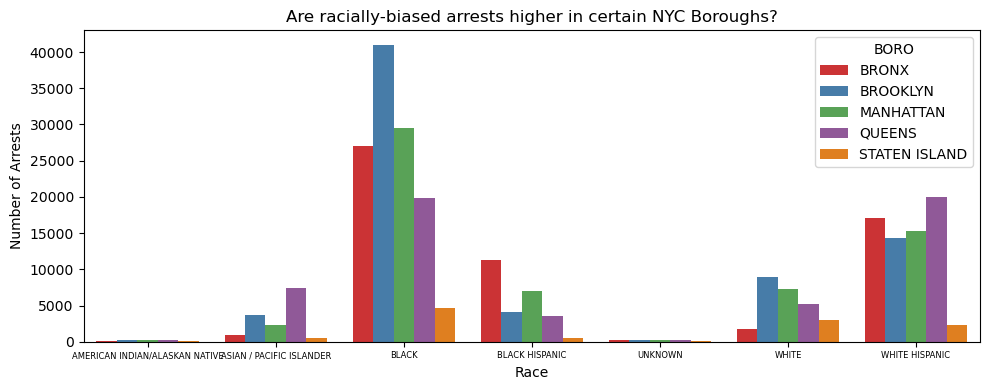

In [177]:
merge_race_boro = merged_df[['PERP_RACE_x', 'BORO']].dropna()
merge_race_boro_counts = merge_race_boro.groupby(['PERP_RACE_x', 'BORO']).size().reset_index(name='Arrest Count')

plt.figure(figsize=(10, 4))
sns.barplot(data=merge_race_boro_counts, x='PERP_RACE_x', y='Arrest Count', hue='BORO', palette='Set1')

plt.title('Are racially-biased arrests higher in certain NYC Boroughs?' )
plt.xlabel('Race')
plt.ylabel('Number of Arrests')
plt.xticks(fontsize=6)
plt.tight_layout()
plt.show()